<a href="https://colab.research.google.com/github/pankajchohan/MLData/blob/main/RandOpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install mlrose

In [4]:
pip install six

In [10]:
import mlrose
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import time
import timeit


# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn import ensemble
from sklearn import svm
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import math
import matplotlib.ticker as plticker
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics 
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.cm as cm
from matplotlib.colors import Normalize
print("Finished installing modules.")

Finished installing modules.


In [14]:
#List of all the functions

outlier_threshold = 0
test_time_list = []
train_time_list = []
accuracy_list = []
lof = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide',
       'total sulfur dioxide','density','pH','sulphates','alcohol']
def get_data():
  url = 'https://raw.githubusercontent.com/pankajchohan/MLData/main/winequality-white.csv'
  df = pd.read_csv(url, delimiter=";")
  print("Finished GetData")
  return df

def split_test(df):
  print("Start Split test")
  X = df.drop(['quality_class','quality'], axis=1)
  y = df['quality_class']
  print("End Split test")
  return train_test_split(X, y, test_size = 0.2, random_state = 1)

def process_train_test_Data(X_train, X_test):
  cols = X_train.columns
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  X_train = pd.DataFrame(X_train, columns=[cols])
  X_test = pd.DataFrame(X_test, columns=[cols])
  return X_train, X_test

def get_quality(row):
   if  row['quality'] < 6:
      return 0
   elif 6 <= row['quality'] :
      return 1

def add_quality_class(df):
  df['quality_class'] = df.apply(lambda row: get_quality(row), axis=1)
  print("finished add quality class")
  return df

def find_ooutlier(df, n, features):
    outlier_indices = []
    for col in features:
        quart1 = np.percentile(df[col], 25)
        quart3 = np.percentile(df[col], 75)
        inqrate = quart3 - quart1
        stp_out = 1.5 * inqrate
        outlier_list_col = df[(df[col] < quart1 - stp_out) | (df[col] > quart3 + stp_out)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)

    return multiple_outliers

def remove_outliers(df):
  outliers_to_drop = find_ooutlier(df, outlier_threshold, lof)
  print(df.shape)
  df = df.drop(outliers_to_drop)
  return df

def resampling(df):
  target_count = df.quality_class.value_counts()
  print('Class 0:', target_count[0])
  print('Class 1:', target_count[1])

  count_class_1, count_class_0 = df.quality_class.value_counts()

  df_class_0 = df[df['quality_class'] == 0]
  df_class_1 = df[df['quality_class'] == 1]

  df_class_0_over = df_class_0.sample(count_class_1, replace=True)
  df_test_over = pd.concat([df_class_1, df_class_0_over], axis=0)

  print('Random over-sampling:')
  print(df_test_over.quality_class.value_counts())

  # df_test_over.quality_class.value_counts().plot(kind='bar', title='Count (quality_class)');
  df = df_test_over.copy()
  plt.figure(figsize=(10, 5))
  plot = df['quality_class'].value_counts().plot(kind="bar")
  plot.set_ylabel("Number of samples", fontsize=15)
  plot.set_xlabel("Classes", fontsize=15)
  plot.set_title("Class distribution Wine Quality", fontsize=15)
  plot.tick_params(labelsize = 15)
  plot.set_xticklabels(["Good", "Bad"], rotation='horizontal', va='top')
  plt.savefig("00_ClassDist_Balanced_Wine.png", pad_inches = 0.01)
  return df

def raw_data():
  df=get_data()
  df = add_quality_class(df)
  X_train, X_test, y_train, y_test = split_test(df)
  X_train, X_test = process_train_test_Data(X_train, X_test)
  return df, X_train, X_test, y_train, y_test

def processed_data():
  df=get_data()
  df = add_quality_class(df)
  df = remove_outliers(df)
  df = resampling(df)
  print(df.shape)
  X_train, X_test, y_train, y_test = split_test(df)
  X_train, X_test = process_train_test_Data(X_train, X_test)
  return df, X_train, X_test, y_train, y_test

def plot_conf_matrix(model, X_train, X_test, y_train, y_test, parameters, fig_name, scoring='accuracy',
                     cv=10, n_jobs=-1, verbose=True):
    # clf = GridSearchCV(model, parameters, cv=cv, n_jobs=n_jobs, verbose=verbose)
    clf = GridSearchCV(model, parameters, cv=3, scoring='accuracy', n_jobs=8, verbose=3, refit=True)
    clf.fit(X_train, y_train)

    print(clf)
    # clf.fit(X_train, y_train)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1)[:, np.newaxis]
    plot = plt.figure(figsize=(10, 10))
    ax = plot.add_subplot(111)
    ax.matshow(conf_matrix, cmap='Blues_r')
    plt.xlabel("Predicted Label", fontsize=30)
    plt.ylabel("True Label", fontsize=30)
    ax.set_xticklabels(clf.classes_, rotation='vertical', va='top')
    ax.set_yticklabels(clf.classes_,  rotation='horizontal', va='baseline')
    ax.xaxis.set_ticks_position('bottom')
    plt.tick_params(labelsize = 15)
    for (i, j), z in np.ndenumerate(conf_matrix):
        if i == j:
          color = 'red'
        else:
          color = 'black'
        ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', color=color, fontsize=20)
    accuracy_score(y_true, y_pred)
    plt.savefig(fig_name, pad_inches = 0.01,  bbox_inches = 'tight')
    return clf
def plot_learning_curve(train_sizes, train_scores, test_scores, fit_times, fig_name):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    # Plot learning curve
    plt.figure(figsize=(10, 10))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="darkorange",
                  label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="navy",
                  label="Cross-validation score")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                          train_scores_mean + train_scores_std, alpha=0.1,
                          color="darkorange")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                          test_scores_mean + test_scores_std, alpha=0.1,
                          color="navy")
    plt.legend(loc="best", fontsize=20)
    #plt.title("LC Decision Tree (Wine)", fontsize=30)
    plt.xlabel("Training Samples", fontsize=30)
    plt.ylabel("Accuracy", fontsize=30)
    plt.tick_params(labelsize = 20)
    plt.ylim((0.45,1.05))
    plt.savefig(fig_name, pad_inches = 0.01,  bbox_inches = 'tight')

def plot_validation_curve(train_scores, test_scores, fig_name, param_name, param_range):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(10, 10))
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
    plt.legend(loc="best", fontsize=20)
    #plt.title("VC Decision Tree (Wine)", fontsize=30)
    plt.xlabel(param_name, fontsize=15)
    plt.ylabel("Accuracy", fontsize=15)
    plt.tick_params(labelsize = 10)
    plt.ylim((0.41,1.05))
    plt.savefig(fig_name, pad_inches = 0.01,  bbox_inches = 'tight')


In [ ]:
eval_df = pd.DataFrame(columns=["model", "recall", "accuracy", "precision"])
(big_df, nn_train_x, nn_test_x, nn_train_y, nn_test_y) = raw_data()

In [ ]:
def randomized_train_nn(rando_algo, train_x, train_y, test_x, test_y, accuracies, times, max_iters=100, max_attempts=3, 
                        early_stopping=False, mutation_prob=0.1, hidden_nodes=[5,5], pop_size=200, to_print=False):
    nn_model = mlrose.NeuralNetwork(hidden_nodes = hidden_nodes, activation = 'tanh', \
                                     algorithm = rando_algo, max_iters = max_iters, \
                                     bias = True, is_classifier = True, learning_rate = 0.1,
                                     clip_max = 5, max_attempts = max_attempts, random_state = 3,curve=True, early_stopping=early_stopping, mutation_prob=mutation_prob,pop_size=pop_size)
    start = time.time()
    nn_model.fit(train_x, train_y)
    end = time.time()
    time_elapsed = end - start
    # Predict labels for train set and assess accuracy
    y_train_pred = nn_model.predict(train_x)
    #y_train_accuracy = accuracy_score(train_y, y_train_pred)
    #print("{0} y train accuracy: {1}".format(rando_algo,y_train_accuracy))
    # Predict labels for test set and assess accuracy
    y_test_pred = nn_model.predict(test_x)
    y_test_accuracy = accuracy_score(test_y, y_test_pred)
    
    accuracies.append(y_test_accuracy)
    times.append(time_elapsed)

    if to_print:
        print(classification_report(test_y, y_test_pred))
        print(confusion_matrix(test_y, y_test_pred))
        print("{0} y test accuracy: {1}".format(rando_algo,y_test_accuracy))
        print("{0} time elapsed: {1}".format(rando_algo,time_elapsed))
    return nn_model

def iterative_train(times, accuracies, iters_range, problem_text, early_stopping=False, mutation_prob=0.1):
    nn_model = None
    for i in iters_range:
        nn_model = randomized_train_nn(problem_text, nn_train_x, nn_train_y, nn_test_x, nn_test_y, accuracies, times, i, 
                                       early_stopping=early_stopping, mutation_prob=mutation_prob)

    plt.plot(iters_range,times,'o-')
    plt.title("Neural Net Training Time over {0}".format(problem_text))
    plt.xlabel("Number of iterations")
    plt.ylabel("Time")
    plt.show()

    plt.plot(iters_range,accuracies,'o-')
    plt.title("Neural Net Test Accuracy over {0}".format(problem_text))
    plt.xlabel("Number of iterations")
    plt.ylabel("Highest Score")
    plt.show()
    return nn_model

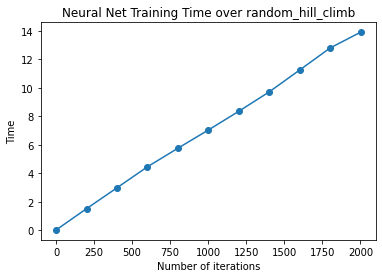

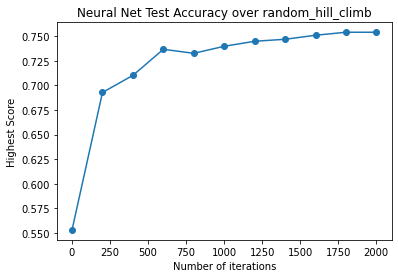

NeuralNetwork(bias=True, clip_max=5, early_stopping=False, hidden_nodes=[5, 5],
              is_classifier=True, learning_rate=0.1, max_iters=2001,
              mutation_prob=0.1, pop_size=200, restarts=0,
              schedule=<mlrose.decay.GeomDecay object at 0x7f28db4df610>)

In [ ]:
hc_times = []
hc_acc = []
iters_range = range(1, 2200, 200)
iterative_train(hc_times, hc_acc, iters_range, "random_hill_climb")

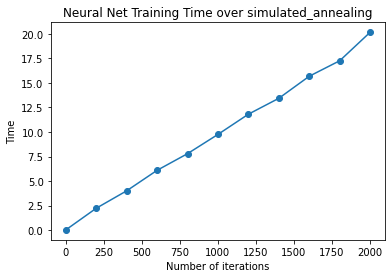

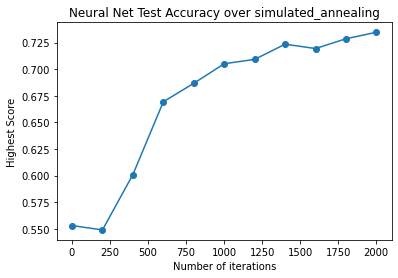

NeuralNetwork(bias=True, clip_max=5, early_stopping=False, hidden_nodes=[5, 5],
              is_classifier=True, learning_rate=0.1, max_iters=2001,
              mutation_prob=0.1, pop_size=200, restarts=0,
              schedule=<mlrose.decay.GeomDecay object at 0x7f28db4df610>)

In [ ]:
sa_times = []
sa_accuracies = []
iters_range = range(1, 2200, 200)
iterative_train(sa_times, sa_accuracies, iters_range, "simulated_annealing")


In [ ]:
sa_accuracies

[0.5530612244897959,
 0.5489795918367347,
 0.6010204081632653,
 0.6693877551020408,
 0.686734693877551,
 0.7051020408163265,
 0.7091836734693877,
 0.7234693877551021,
 0.7193877551020408,
 0.7285714285714285,
 0.7346938775510204]

In [ ]:
ga_times = []
ga_accuracies = []
iters_range = range(1, 2200, 200)
iterative_train(ga_times, ga_accuracies, iters_range, "genetic_alg")

In [ ]:
mimic_times = []
mimic_accuracies = []
iters_range = range(1, 2200, 200)
iterative_train(mimic_times, mimic_accuracies, iters_range, "mimic")

In [ ]:
nn_rhc_clf = mlrose.NeuralNetwork(hidden_nodes = [30], activation = 'relu', 
                                         bias = True, is_classifier = True, random_state = 11)
print(nn_rhc_clf)

NeuralNetwork(bias=True, clip_max=10000000000.0, early_stopping=False,
              hidden_nodes=[30], is_classifier=True, learning_rate=0.1,
              max_iters=100, mutation_prob=0.1, pop_size=200, restarts=0,
              schedule=<mlrose.decay.GeomDecay object at 0x7f28db4df610>)


In [8]:
eeg, Xtrain, Xtest, ytrain, ytest = raw_data()

Finished GetData
finished add quality class
Start Split test
End Split test


In [15]:
start = timeit.default_timer()
nn_gd = mlrose.NeuralNetwork(hidden_nodes = [120, 70, 30],
                          activation = 'relu',
                          algorithm = 'gradient_descent',
                          max_iters = 1400,
                          bias = True,
                          is_classifier = True,
                          learning_rate = 1.0,
                          # early_stopping = True,
                          # clip_max = 10,
                          # max_attempts = 20,
                          random_state = 42,
#                           restarts = restart,
                          curve = True)
nn_gd.fit(Xtrain, ytrain)
end = timeit.default_timer()
y_pred = nn_gd.predict(Xtest)
score = accuracy_score(ytest, y_pred)
elapsed_time = end - start
results_gd = {'model': nn_gd,
      'time': elapsed_time,
      'score': score,
      'fitness curve': nn_gd.fitness_curve}

results_gd

/usr/local/lib/python3.7/dist-packages/mlrose/activation.py:77: RuntimeWarning: overflow encountered in exp
  fx = 1/(1 + np.exp(-x))
/usr/local/lib/python3.7/dist-packages/mlrose/activation.py:77: RuntimeWarning: overflow encountered in exp
  fx = 1/(1 + np.exp(-x))


{'fitness curve': array([-10.68469422, -22.93769683,  -0.6920857 , ...,  -0.6920857 ,
         -0.6920857 ,  -0.6920857 ]),
 'model': NeuralNetwork(bias=True, clip_max=10000000000.0, early_stopping=False,
               hidden_nodes=[120, 70, 30], is_classifier=True, learning_rate=1.0,
               max_iters=1400, mutation_prob=0.1, pop_size=200, restarts=0,
               schedule=<mlrose.decay.GeomDecay object at 0x7f51466c8450>),
 'score': 0.3326530612244898,
 'time': 124.6835687979983}

In [16]:
restart_list = [5,10,40,80]
results_rhc = []
for restart in restart_list:
    start = timeit.default_timer()
    print("start", start)
    nn_rhc = mlrose.NeuralNetwork(hidden_nodes = [40],
                              activation = 'relu',
                              algorithm = 'random_hill_climb', 
                              max_iters = 800,
                              bias = True, 
                              is_classifier = True, 
                              learning_rate = 1,
                              # early_stopping = True,
                              # clip_max = 10,
                              # max_attempts = 20,
                              random_state = 42,
                              restarts = restart,
                              curve = True)
    nn_rhc.fit(Xtrain, ytrain)
    end = timeit.default_timer()
    y_pred = nn_rhc.predict(Xtest)
    score = accuracy_score(ytest, y_pred)
    elapsed_time = end - start
    tmp = {'model': nn_rhc,
          'time': elapsed_time,
          'score': score,
           'restart': restart,
          'fitness curve': nn_rhc.fitness_curve}
    results_rhc.append(tmp)
    print("end", end)
    print(results_rhc)


start 26915.006593968
end 26985.387684453
[{'model': NeuralNetwork(bias=True, clip_max=10000000000.0, early_stopping=False,
              hidden_nodes=[40], is_classifier=True, learning_rate=1,
              max_iters=1400, mutation_prob=0.1, pop_size=200, restarts=5,
              schedule=<mlrose.decay.GeomDecay object at 0x7f51466c8450>), 'time': 70.38109048499973, 'score': 0.7408163265306122, 'restart': 5, 'fitness curve': array([-1.34317015, -1.34317015, -1.34317015, ..., -0.52085353,
       -0.52085353, -0.52085353])}]
start 26985.391528031
end 27113.371974234
[{'model': NeuralNetwork(bias=True, clip_max=10000000000.0, early_stopping=False,
              hidden_nodes=[40], is_classifier=True, learning_rate=1,
              max_iters=1400, mutation_prob=0.1, pop_size=200, restarts=5,
              schedule=<mlrose.decay.GeomDecay object at 0x7f51466c8450>), 'time': 70.38109048499973, 'score': 0.7408163265306122, 'restart': 5, 'fitness curve': array([-1.34317015, -1.34317015, -1.34